Can we use a clustering algorithm to identify the Y1 TF outlier galaxies?

In [27]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import Planck18, LambdaCDM, FlatLambdaCDM
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import pickle

from sklearn.cluster import HDBSCAN

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from z_CMB_convert import convert_z_frame
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [4]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Data

In [5]:
SGA_TF = Table.read('SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Convert to CMB frame

In [7]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

## Photometric corrections

### Survey offsets

In [9]:
sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### MW dust corrections

In [10]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [11]:
MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [12]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [13]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [14]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [15]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction

This is based off a linear fit to ($b/a$, $m_r$) to remove any correlation between $b/a$ and $m_r$.

In [18]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [20]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

### Apply corrections

In [21]:
SGA_TF['G_MAG_SB26_CORR'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
SGA_TF['Z_MAG_SB26_CORR'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [22]:
SGA_TF['G_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
SGA_TF['Z_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Compute the absolute magnitudes based on the redshift

In [25]:
cosmo = LambdaCDM(H0=H0, 
                  Om0=Planck18.Om0, 
                  Tcmb0=Planck18.Tcmb0, 
                  Neff=Planck18.Neff, 
                  m_nu=Planck18.m_nu, 
                  Ob0=Planck18.Ob0, 
                  Ode0=Planck18.Ode0)
SGA_TF['MU_ZCMB'] = cosmo.distmod(SGA_TF['Z_DESI_CMB'])

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value

In [28]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(SGA_TF['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI_CMB'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

SGA_TF['MU_ZCMB_ERR'] = mu_err

SGA_TF['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)

100%|████████████████████████████████████| 10262/10262 [00:39<00:00, 262.19it/s]


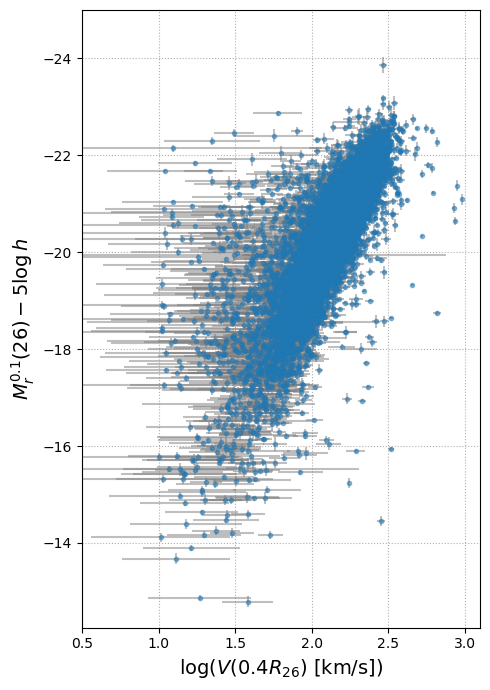

In [29]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'], 
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

# Run a clustering algorithm on ($M_r$, $\log (V(0.4R_{26}))$)

In [87]:
# clusterer = HDBSCAN(cluster_selection_epsilon=0.05) <-- This is what I used
clusterer = HDBSCAN(cluster_selection_epsilon=0.07) #<-- This could be better, only keeping cluster #12

data = np.array([SGA_TF['R_ABSMAG_SB26'], np.log10(SGA_TF['V_0p4R26'])])
# data.shape

clusterer.fit(data.T)

,min_cluster_size,5
,min_samples,None
,cluster_selection_epsilon,0.07
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [88]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

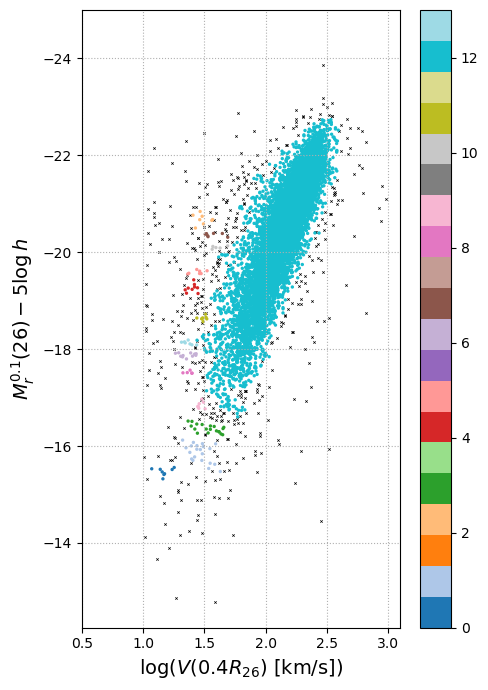

In [89]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

noise = clusterer.labels_ < 0
plt.scatter(np.log10(SGA_TF['V_0p4R26'][noise]), 
            SGA_TF['R_ABSMAG_SB26'][noise], 
            s=3,
            linewidths=0.5,
            c='k',
            marker='x')

plt.scatter(np.log10(SGA_TF['V_0p4R26'][~noise]), 
            SGA_TF['R_ABSMAG_SB26'][~noise], 
            s=2,
            c=clusterer.labels_[~noise],
            cmap='tab20')
plt.colorbar()

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

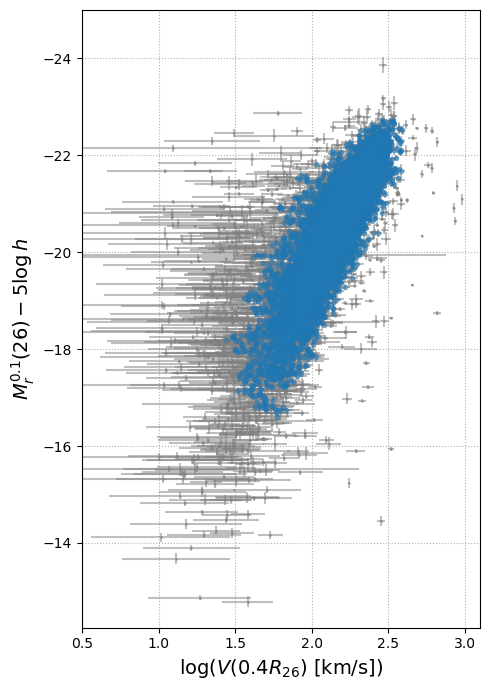

In [90]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

keep_cluster_min = 12

# sample = clusterer.labels_ >= keep_cluster_min
sample = clusterer.labels_ == 12
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

# sample = clusterer.labels_ < keep_cluster_min
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][~sample]), 
             SGA_TF['R_ABSMAG_SB26'][~sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][~sample]/SGA_TF['V_0p4R26'][~sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][~sample], 
             fmt='.', 
             ms=2,
             color='gray',
             alpha=0.5, 
             ecolor='gray')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);